<span style="font-size:24px; font-weight:bold; color:black;">Step 1: Data Understanding and Preprocessing</span>


In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from wordcloud import WordCloud

In [35]:
# Load the dataset
data = pd.read_csv('Amazon_Reviews.csv',low_memory=False)

# Selecting relevant columns for sentiment analysis
data = data[['reviews.rating', 'reviews.text', 'reviews.title', 'reviews.doRecommend']]

# Checking for missing values in each column
print("Missing values in each column:\n", data.isnull().sum())
data.dropna(subset=['reviews.rating', 'reviews.text'], inplace=True) # Dropping rows with missing rating or text

# Defining a function to encode the sentiment based on the rating
def encode_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'
# Applying the encoding function to create a 'sentiment' column
data['sentiment'] = data['reviews.rating'].apply(encode_sentiment)

# Dropping the 'reviews.rating' column as it's no longer needed
data.drop(columns=['reviews.rating'], inplace=True)


print(data.head())
print(data['sentiment'].value_counts())

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['reviews.text'], data['sentiment'], test_size=0.2, random_state=42)

# Printing the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


Missing values in each column:
 reviews.rating           0
reviews.text             0
reviews.title            2
reviews.doRecommend    161
dtype: int64
                                        reviews.text  \
0  This is a review of the Kindle Paperwhite laun...   
1  I've had lots of tablets in the past, mostly f...   
2  Cord cutter here. We had been wanting to dump ...   
3  Even when I’m outside in bright sunlight, the ...   
4  Despite not being able to get one of these fro...   

                                       reviews.title reviews.doRecommend  \
0  Superb reading device - but which one's best f...                 NaN   
1            Great price on an awesome little tablet                True   
2                        Great buy for cable cutters                True   
3                     Reasons I Love My Kindle Oasis                True   
4                   Remarkably Small and Lightweight                True   

  sentiment  
0  Positive  
1  Positive  
2  Positive

((8000,), (2000,), (8000,), (2000,))

<span style="font-size:24px; font-weight:bold; color:black;">Step 2: Text Preprocessing and Feature Extraction</span>


In [6]:
# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords, lemmatizer, and stemmer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Function to clean text with stemming and lemmatization
def clean_text(text):
    # Remove non-alphabetical characters and lowercase the text
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    # Tokenize, lemmatize, stem, and remove stopwords
    text = ' '.join([stemmer.stem(lemmatizer.lemmatize(word)) for word in text.split() if word not in stop_words])
    return text

# Apply cleaning to the training and test sets
X_train_cleaned = X_train.apply(clean_text)
X_test_cleaned = X_test.apply(clean_text)

# Initialize the TfidfVectorizer for feature extraction
# Limiting max_features to 5000 to reduce dimensionality
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on training data and transform both training and test sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_cleaned)
X_test_tfidf = tfidf_vectorizer.transform(X_test_cleaned)

# Display the shape of the resulting TF-IDF matrices
print(f"Training data shape (TF-IDF features): {X_train_tfidf.shape}")
print(f"Testing data shape (TF-IDF features): {X_test_tfidf.shape}")

# Convert target labels to arrays for model compatibility
y_train_encoded = y_train.values
y_test_encoded = y_test.values


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rnjre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rnjre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Training data shape (TF-IDF features): (8000, 5000)
Testing data shape (TF-IDF features): (2000, 5000)


<span style="font-size:24px; font-weight:bold; color:black;">Step 3: Model Training and Evaluation</span>


In [8]:
# Dictionary to store model results
model_results = {}

# Function to train and evaluate model with metrics
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)

    print(f"--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Cohen’s Kappa: {kappa:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    # Store results
    model_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Cohen’s Kappa": kappa
    }

# Initialize models
log_reg = LogisticRegression(max_iter=200)
naive_bayes = MultinomialNB()
svm = SVC(kernel='linear', probability=True)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
gradient_boosting = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Evaluate each model
evaluate_model(log_reg, X_train_tfidf, y_train_encoded, X_test_tfidf, y_test_encoded, "Logistic Regression")
evaluate_model(naive_bayes, X_train_tfidf, y_train_encoded, X_test_tfidf, y_test_encoded, "Naive Bayes")
evaluate_model(svm, X_train_tfidf, y_train_encoded, X_test_tfidf, y_test_encoded, "Support Vector Machine")
evaluate_model(random_forest, X_train_tfidf, y_train_encoded, X_test_tfidf, y_test_encoded, "Random Forest")
evaluate_model(gradient_boosting, X_train_tfidf, y_train_encoded, X_test_tfidf, y_test_encoded, "Gradient Boosting")

# Print model comparison
print("\n--- Model Comparison ---")
for model_name, metrics in model_results.items():
    print(f"{model_name}: {metrics}")


--- Logistic Regression Performance ---
Accuracy: 0.9130
Precision: 0.8868
Recall: 0.9130
F1 Score: 0.8824
Cohen’s Kappa: 0.2031

Classification Report:
               precision    recall  f1-score   support

    Negative       0.74      0.19      0.30        75
     Neutral       0.50      0.06      0.11       115
    Positive       0.92      1.00      0.96      1810

    accuracy                           0.91      2000
   macro avg       0.72      0.41      0.45      2000
weighted avg       0.89      0.91      0.88      2000

--- Naive Bayes Performance ---
Accuracy: 0.9050
Precision: 0.8190
Recall: 0.9050
F1 Score: 0.8599
Cohen’s Kappa: 0.0000

Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        75
     Neutral       0.00      0.00      0.00       115
    Positive       0.91      1.00      0.95      1810

    accuracy                           0.91      2000
   macro avg       0.30      0.33      0.32    

<span style="font-size:20px; font-weight:bold; color:black;">3.1 : Model Evaluation - SVM</span>


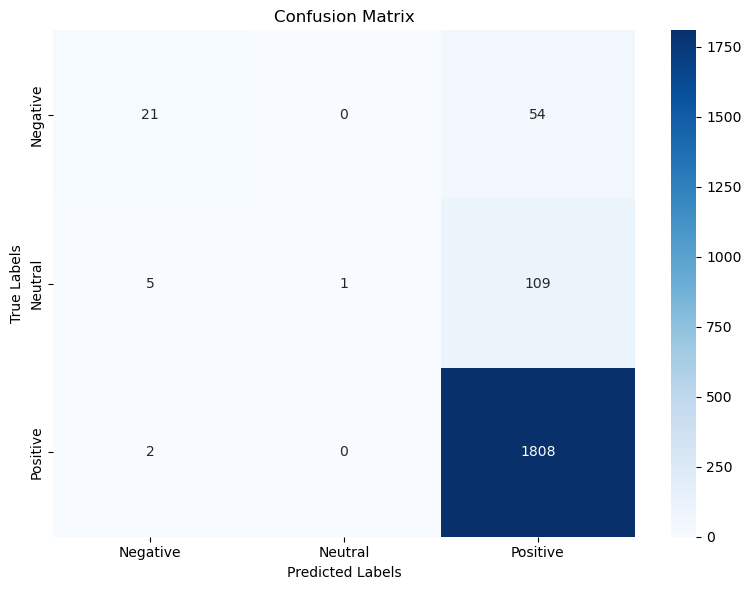

Percentage of Correctly Predicted Positive Reviews: 99.89%
Percentage of Correctly Predicted Neutral Reviews: 0.87%
Percentage of Correctly Predicted Negative Reviews: 28.00%


In [14]:
# Ensure consistent label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encode training labels
y_test_encoded = label_encoder.transform(y_test)  # Encode test labels

# Get predictions from the SVM model
svm_predictions = svm.predict(X_test_tfidf)

# Convert SVM predictions to encoded labels (to ensure compatibility)
svm_predictions_encoded = label_encoder.transform(svm_predictions)

# Calculate confusion matrix
cm = confusion_matrix(y_test_encoded, svm_predictions_encoded)

# Generate the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.tight_layout()
plt.savefig("confusion_matrix_plot_corrected.png")
plt.show()

# Calculate the percentage of correctly predicted outcomes for each class
positive_accuracy = (cm[2, 2] / cm[2].sum()) * 100  # TP for Positive / Total Positive
neutral_accuracy = (cm[1, 1] / cm[1].sum()) * 100  # TP for Neutral / Total Neutral
negative_accuracy = (cm[0, 0] / cm[0].sum()) * 100  # TP for Negative / Total Negative

# Print the results
print(f"Percentage of Correctly Predicted Positive Reviews: {positive_accuracy:.2f}%")
print(f"Percentage of Correctly Predicted Neutral Reviews: {neutral_accuracy:.2f}%")
print(f"Percentage of Correctly Predicted Negative Reviews: {negative_accuracy:.2f}%")


<span style="font-size:24px; font-weight:bold; color:black;">Step 4: Hyperparameter tuning and SMOT</span>


In [16]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train_encoded)

# Check the class distribution after SMOTE
print("Class distribution after applying SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Function to optimize and evaluate the model
def optimize_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test, model_name):
    grid_search = GridSearchCV(model, param_grid, scoring='f1_weighted', cv=5)
    grid_search.fit(X_train, y_train)

    # Best model after hyperparameter tuning
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)

    # Display results
    print(f"\n--- Optimized {model_name} Performance ---")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Cohen’s Kappa: {kappa:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    # Store results
    model_results[model_name] = {
        "Best Parameters": grid_search.best_params_,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Cohen’s Kappa": kappa
    }

# Hyperparameter grids for each model
param_grid_logreg = {
    'C': [0.1, 1, 10],
    'class_weight': [None, 'balanced']
}

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'class_weight': [None, 'balanced']
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'class_weight': [None, 'balanced']
}

param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.5]
}

# Dictionary to store model results
model_results = {}

# Evaluate and optimize each model
optimize_and_evaluate_model(LogisticRegression(max_iter=200), param_grid_logreg, X_train_balanced, y_train_balanced, X_test_tfidf, y_test_encoded, "Logistic Regression")
optimize_and_evaluate_model(MultinomialNB(), param_grid_nb, X_train_balanced, y_train_balanced, X_test_tfidf, y_test_encoded, "Naive Bayes")
optimize_and_evaluate_model(SVC(probability=True), param_grid_svm, X_train_balanced, y_train_balanced, X_test_tfidf, y_test_encoded, "Support Vector Machine")
optimize_and_evaluate_model(RandomForestClassifier(random_state=42), param_grid_rf, X_train_balanced, y_train_balanced, X_test_tfidf, y_test_encoded, "Random Forest")
optimize_and_evaluate_model(GradientBoostingClassifier(random_state=42), param_grid_gb, X_train_balanced, y_train_balanced, X_test_tfidf, y_test_encoded, "Gradient Boosting")

# Print the comparison of optimized model results
print("\n--- Optimized Model Comparison ---")
for model_name, metrics in model_results.items():
    print(f"{model_name}: {metrics}")


Class distribution after applying SMOTE:
2    7185
0    7185
1    7185
Name: count, dtype: int64

--- Optimized Logistic Regression Performance ---
Best Parameters: {'C': 10, 'class_weight': None}
Accuracy: 0.8675
Precision: 0.8879
Recall: 0.8675
F1 Score: 0.8768
Cohen’s Kappa: 0.3374

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.43      0.44        75
           1       0.23      0.35      0.28       115
           2       0.95      0.92      0.93      1810

    accuracy                           0.87      2000
   macro avg       0.54      0.56      0.55      2000
weighted avg       0.89      0.87      0.88      2000


--- Optimized Naive Bayes Performance ---
Best Parameters: {'alpha': 0.1}
Accuracy: 0.8145
Precision: 0.8827
Recall: 0.8145
F1 Score: 0.8440
Cohen’s Kappa: 0.2616

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.41      0.33        75
          

<span style="font-size:20px; font-weight:bold; color:black;">4.1 : Model Evaluation - SVM</span>


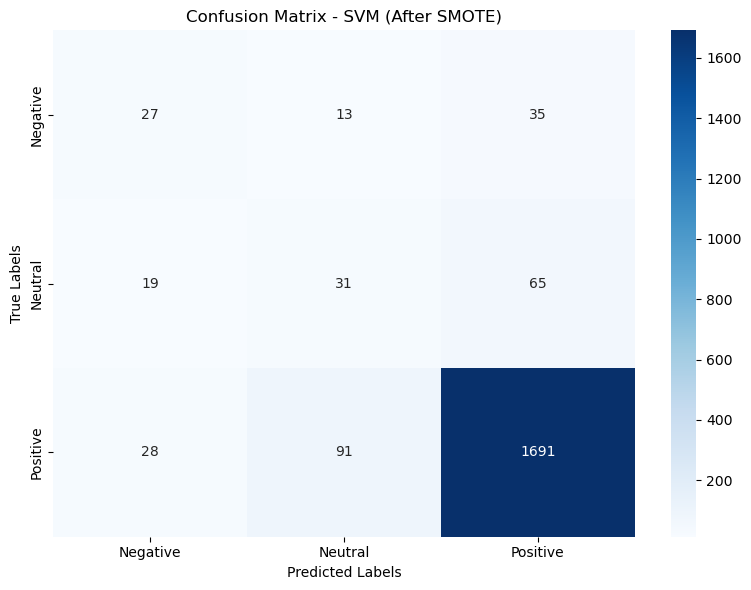

Percentage of Correctly Predicted Positive Reviews (After SMOTE): 93.43%
Percentage of Correctly Predicted Neutral Reviews (After SMOTE): 26.96%
Percentage of Correctly Predicted Negative Reviews (After SMOTE): 36.00%


In [30]:
# Train the SVM model after SMOTE
svm_model = SVC(probability=True, C=10, kernel='linear', class_weight=None)  # Best parameters after SMOTE
svm_model.fit(X_train_balanced, y_train_balanced)  # Train on SMOTE-balanced data
y_pred = svm_model.predict(X_test_tfidf)

# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix - SVM (After SMOTE)")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.tight_layout()
plt.savefig("svm_after_smote_confusion_matrix.png")
plt.show()

# Calculate the percentage of correctly predicted outcomes for each class
positive_accuracy = (cm[2, 2] / cm[2].sum()) * 100  # TP for Positive / Total Positive
neutral_accuracy = (cm[1, 1] / cm[1].sum()) * 100  # TP for Neutral / Total Neutral
negative_accuracy = (cm[0, 0] / cm[0].sum()) * 100  # TP for Negative / Total Negative

# Print the results
print(f"Percentage of Correctly Predicted Positive Reviews (After SMOTE): {positive_accuracy:.2f}%")
print(f"Percentage of Correctly Predicted Neutral Reviews (After SMOTE): {neutral_accuracy:.2f}%")
print(f"Percentage of Correctly Predicted Negative Reviews (After SMOTE): {negative_accuracy:.2f}%")


<span style="font-size:20px; font-weight:bold; color:black;">4.2 : Model Evaluation - Logistic Regression</span>


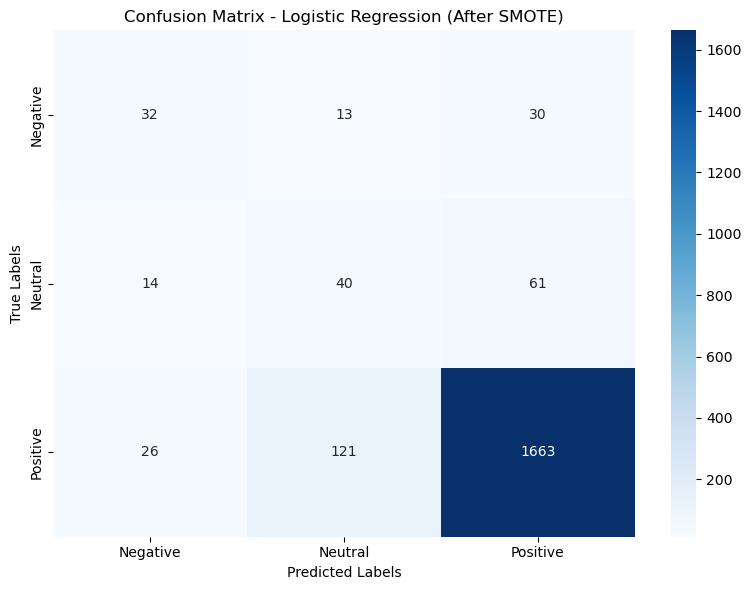

Percentage of Correctly Predicted Positive Reviews (After SMOTE): 91.88%
Percentage of Correctly Predicted Neutral Reviews (After SMOTE): 34.78%
Percentage of Correctly Predicted Negative Reviews (After SMOTE): 42.67%


In [32]:
# Train the Logistic Regression model after SMOTE
logistic_model = LogisticRegression(max_iter=200, C=10, class_weight=None)  # Best parameters after SMOTE
logistic_model.fit(X_train_balanced, y_train_balanced)  # Train on SMOTE-balanced data
y_pred_logistic = logistic_model.predict(X_test_tfidf)

# Confusion matrix
cm_logistic = confusion_matrix(y_test_encoded, y_pred_logistic)

# Heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix - Logistic Regression (After SMOTE)")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.tight_layout()
plt.savefig("logistic_regression_confusion_matrix.png")
plt.show()

# Calculate the percentage of correctly predicted outcomes for each class
positive_accuracy = (cm_logistic[2, 2] / cm_logistic[2].sum()) * 100  # TP for Positive / Total Positive
neutral_accuracy = (cm_logistic[1, 1] / cm_logistic[1].sum()) * 100  # TP for Neutral / Total Neutral
negative_accuracy = (cm_logistic[0, 0] / cm_logistic[0].sum()) * 100  # TP for Negative / Total Negative

# Print the results
print(f"Percentage of Correctly Predicted Positive Reviews (After SMOTE): {positive_accuracy:.2f}%")
print(f"Percentage of Correctly Predicted Neutral Reviews (After SMOTE): {neutral_accuracy:.2f}%")
print(f"Percentage of Correctly Predicted Negative Reviews (After SMOTE): {negative_accuracy:.2f}%")


<span style="font-size:24px; font-weight:bold; color:black;">Step 5 : Experiment with Different parameters</span>


<span style="font-size:15px; font-weight:bold; color:black;">C= 10 and Class_weight= Balanced</span>


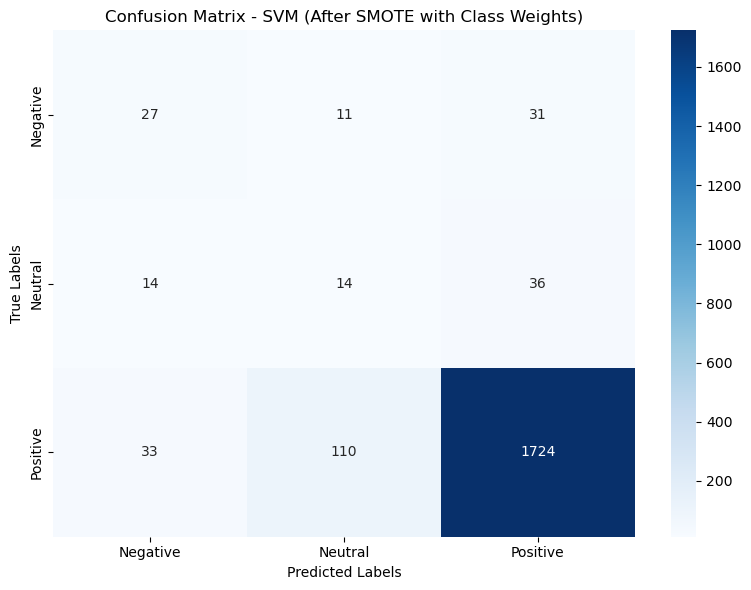

SVM with Class Weights:
Percentage of Correctly Predicted Positive Reviews: 92.34%
Percentage of Correctly Predicted Neutral Reviews: 21.88%
Percentage of Correctly Predicted Negative Reviews: 39.13%


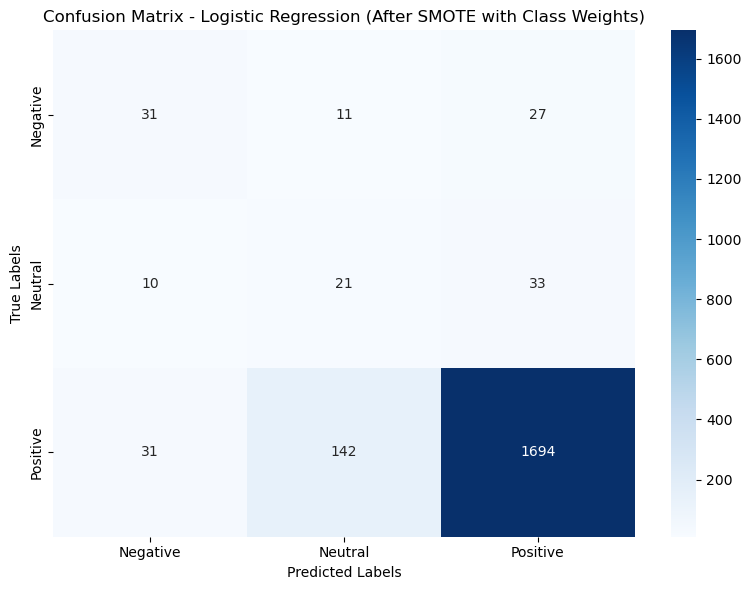

Logistic Regression with Class Weights:
Percentage of Correctly Predicted Positive Reviews: 90.73%
Percentage of Correctly Predicted Neutral Reviews: 32.81%
Percentage of Correctly Predicted Negative Reviews: 44.93%
Overall Performance Metrics for SVM with Class Weights:
Accuracy: 0.8825
Precision: 0.9145
Recall: 0.8825
F1 Score: 0.8974

Overall Performance Metrics for Logistic Regression with Class Weights:
Accuracy: 0.8730
Precision: 0.9203
Recall: 0.8730
F1 Score: 0.8942


In [72]:
# Compute class weights for SVM
unique_classes = np.unique(y_train_balanced)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_balanced
)
class_weight_dict = dict(zip(unique_classes, class_weights))

# Train SVM with class weights
svm_model_weighted = SVC(kernel='linear', C=10, class_weight=class_weight_dict, probability=True)
svm_model_weighted.fit(X_train_balanced, y_train_balanced)
y_pred_svm_weighted = svm_model_weighted.predict(X_test_tfidf)

# Confusion matrix for SVM with class weights
cm_svm_weighted = confusion_matrix(y_test_encoded, y_pred_svm_weighted)

# Heatmap for SVM
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_weighted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix - SVM (After SMOTE with Class Weights)")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.tight_layout()
plt.savefig("svm_weighted_confusion_matrix.png")
plt.show()

# Class-wise accuracy for SVM
positive_accuracy_svm = (cm_svm_weighted[2, 2] / cm_svm_weighted[2].sum()) * 100
neutral_accuracy_svm = (cm_svm_weighted[1, 1] / cm_svm_weighted[1].sum()) * 100
negative_accuracy_svm = (cm_svm_weighted[0, 0] / cm_svm_weighted[0].sum()) * 100

print(f"SVM with Class Weights:")
print(f"Percentage of Correctly Predicted Positive Reviews: {positive_accuracy_svm:.2f}%")
print(f"Percentage of Correctly Predicted Neutral Reviews: {neutral_accuracy_svm:.2f}%")
print(f"Percentage of Correctly Predicted Negative Reviews: {negative_accuracy_svm:.2f}%")

# Train Logistic Regression with class weights
logistic_model_weighted = LogisticRegression(max_iter=200, C=10, class_weight='balanced')
logistic_model_weighted.fit(X_train_balanced, y_train_balanced)
y_pred_logistic_weighted = logistic_model_weighted.predict(X_test_tfidf)

# Confusion matrix for Logistic Regression with class weights
cm_logistic_weighted = confusion_matrix(y_test_encoded, y_pred_logistic_weighted)

# Heatmap for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logistic_weighted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix - Logistic Regression (After SMOTE with Class Weights)")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.tight_layout()
plt.savefig("logistic_weighted_confusion_matrix.png")
plt.show()

# Class-wise accuracy for Logistic Regression
positive_accuracy_logistic = (cm_logistic_weighted[2, 2] / cm_logistic_weighted[2].sum()) * 100
neutral_accuracy_logistic = (cm_logistic_weighted[1, 1] / cm_logistic_weighted[1].sum()) * 100
negative_accuracy_logistic = (cm_logistic_weighted[0, 0] / cm_logistic_weighted[0].sum()) * 100

print(f"Logistic Regression with Class Weights:")
print(f"Percentage of Correctly Predicted Positive Reviews: {positive_accuracy_logistic:.2f}%")
print(f"Percentage of Correctly Predicted Neutral Reviews: {neutral_accuracy_logistic:.2f}%")
print(f"Percentage of Correctly Predicted Negative Reviews: {negative_accuracy_logistic:.2f}%")

# Overall metrics for SVM with class weights
svm_accuracy = accuracy_score(y_test_encoded, y_pred_svm_weighted)
svm_precision = precision_score(y_test_encoded, y_pred_svm_weighted, average='weighted')
svm_recall = recall_score(y_test_encoded, y_pred_svm_weighted, average='weighted')
svm_f1 = f1_score(y_test_encoded, y_pred_svm_weighted, average='weighted')

print("Overall Performance Metrics for SVM with Class Weights:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1 Score: {svm_f1:.4f}")

# Overall metrics for Logistic Regression with class weights
logistic_accuracy = accuracy_score(y_test_encoded, y_pred_logistic_weighted)
logistic_precision = precision_score(y_test_encoded, y_pred_logistic_weighted, average='weighted')
logistic_recall = recall_score(y_test_encoded, y_pred_logistic_weighted, average='weighted')
logistic_f1 = f1_score(y_test_encoded, y_pred_logistic_weighted, average='weighted')

print("\nOverall Performance Metrics for Logistic Regression with Class Weights:")
print(f"Accuracy: {logistic_accuracy:.4f}")
print(f"Precision: {logistic_precision:.4f}")
print(f"Recall: {logistic_recall:.4f}")
print(f"F1 Score: {logistic_f1:.4f}")


<span style="font-size:15px; font-weight:bold; color:black;">C= 1 and Class_weight= Balanced</span>


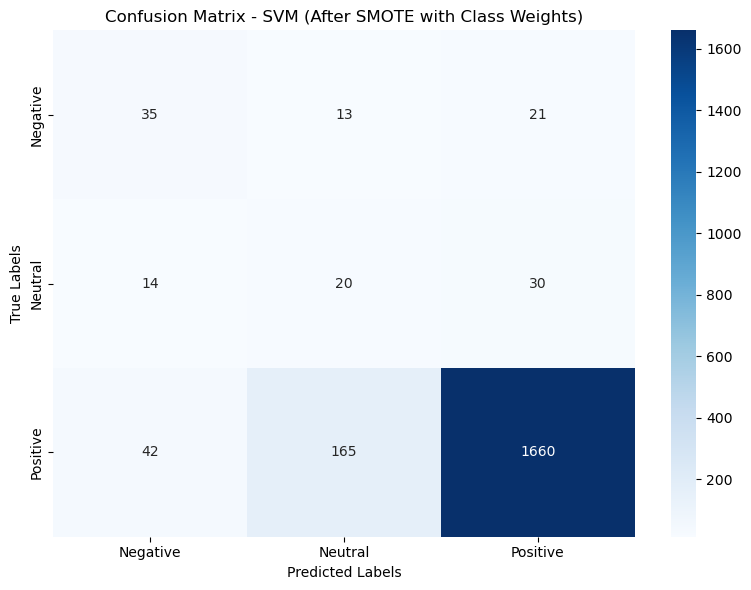

SVM with Class Weights:
Percentage of Correctly Predicted Positive Reviews: 88.91%
Percentage of Correctly Predicted Neutral Reviews: 31.25%
Percentage of Correctly Predicted Negative Reviews: 50.72%


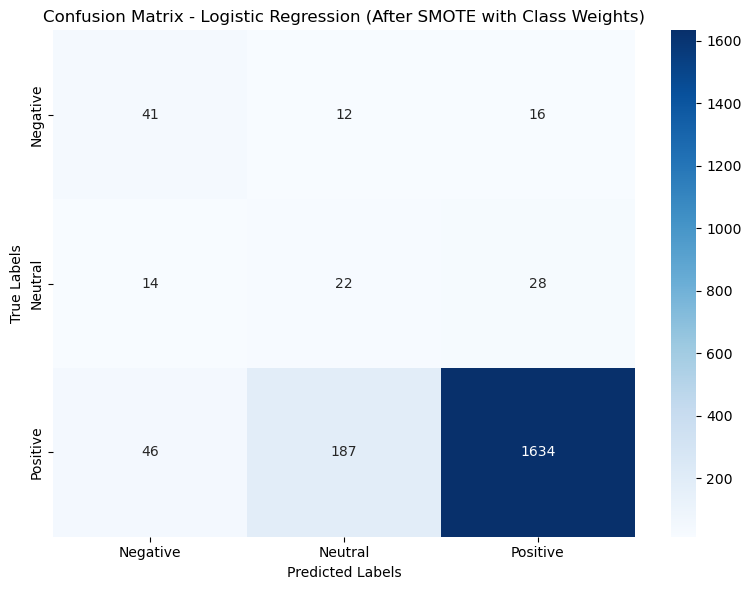

Logistic Regression with Class Weights:
Percentage of Correctly Predicted Positive Reviews: 87.52%
Percentage of Correctly Predicted Neutral Reviews: 34.38%
Percentage of Correctly Predicted Negative Reviews: 59.42%
Overall Performance Metrics for SVM with Class Weights:
Accuracy: 0.8575
Precision: 0.9222
Recall: 0.8575
F1 Score: 0.8862

Overall Performance Metrics for Logistic Regression with Class Weights:
Accuracy: 0.8485
Precision: 0.9262
Recall: 0.8485
F1 Score: 0.8821


In [68]:
# Compute class weights for SVM
unique_classes = np.unique(y_train_balanced)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_balanced
)
class_weight_dict = dict(zip(unique_classes, class_weights))

# Train SVM with class weights
svm_model_weighted = SVC(kernel='linear', C=1, class_weight=class_weight_dict, probability=True)
svm_model_weighted.fit(X_train_balanced, y_train_balanced)
y_pred_svm_weighted = svm_model_weighted.predict(X_test_tfidf)

# Confusion matrix for SVM with class weights
cm_svm_weighted = confusion_matrix(y_test_encoded, y_pred_svm_weighted)

# Heatmap for SVM
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_weighted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix - SVM (After SMOTE with Class Weights)")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.tight_layout()
plt.savefig("svm_weighted_confusion_matrix.png")
plt.show()

# Class-wise accuracy for SVM
positive_accuracy_svm = (cm_svm_weighted[2, 2] / cm_svm_weighted[2].sum()) * 100
neutral_accuracy_svm = (cm_svm_weighted[1, 1] / cm_svm_weighted[1].sum()) * 100
negative_accuracy_svm = (cm_svm_weighted[0, 0] / cm_svm_weighted[0].sum()) * 100

print(f"SVM with Class Weights:")
print(f"Percentage of Correctly Predicted Positive Reviews: {positive_accuracy_svm:.2f}%")
print(f"Percentage of Correctly Predicted Neutral Reviews: {neutral_accuracy_svm:.2f}%")
print(f"Percentage of Correctly Predicted Negative Reviews: {negative_accuracy_svm:.2f}%")

# Train Logistic Regression with class weights
logistic_model_weighted = LogisticRegression(max_iter=200, C=1, class_weight='balanced')
logistic_model_weighted.fit(X_train_balanced, y_train_balanced)
y_pred_logistic_weighted = logistic_model_weighted.predict(X_test_tfidf)

# Confusion matrix for Logistic Regression with class weights
cm_logistic_weighted = confusion_matrix(y_test_encoded, y_pred_logistic_weighted)

# Heatmap for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logistic_weighted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix - Logistic Regression (After SMOTE with Class Weights)")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.tight_layout()
plt.savefig("logistic_weighted_confusion_matrix.png")
plt.show()

# Class-wise accuracy for Logistic Regression
positive_accuracy_logistic = (cm_logistic_weighted[2, 2] / cm_logistic_weighted[2].sum()) * 100
neutral_accuracy_logistic = (cm_logistic_weighted[1, 1] / cm_logistic_weighted[1].sum()) * 100
negative_accuracy_logistic = (cm_logistic_weighted[0, 0] / cm_logistic_weighted[0].sum()) * 100

print(f"Logistic Regression with Class Weights:")
print(f"Percentage of Correctly Predicted Positive Reviews: {positive_accuracy_logistic:.2f}%")
print(f"Percentage of Correctly Predicted Neutral Reviews: {neutral_accuracy_logistic:.2f}%")
print(f"Percentage of Correctly Predicted Negative Reviews: {negative_accuracy_logistic:.2f}%")

# Overall metrics for SVM with class weights
svm_accuracy = accuracy_score(y_test_encoded, y_pred_svm_weighted)
svm_precision = precision_score(y_test_encoded, y_pred_svm_weighted, average='weighted')
svm_recall = recall_score(y_test_encoded, y_pred_svm_weighted, average='weighted')
svm_f1 = f1_score(y_test_encoded, y_pred_svm_weighted, average='weighted')

print("Overall Performance Metrics for SVM with Class Weights:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1 Score: {svm_f1:.4f}")

# Overall metrics for Logistic Regression with class weights
logistic_accuracy = accuracy_score(y_test_encoded, y_pred_logistic_weighted)
logistic_precision = precision_score(y_test_encoded, y_pred_logistic_weighted, average='weighted')
logistic_recall = recall_score(y_test_encoded, y_pred_logistic_weighted, average='weighted')
logistic_f1 = f1_score(y_test_encoded, y_pred_logistic_weighted, average='weighted')

print("\nOverall Performance Metrics for Logistic Regression with Class Weights:")
print(f"Accuracy: {logistic_accuracy:.4f}")
print(f"Precision: {logistic_precision:.4f}")
print(f"Recall: {logistic_recall:.4f}")
print(f"F1 Score: {logistic_f1:.4f}")


<span style="font-size:24px; font-weight:bold; color:black;">Step 6 : Model Comparison</span>


In [93]:
# Data for the comparison table (metrics as rows, methods as columns)
data = {
    "Metric": [
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
        "Percentage of Correctly Predicted Positive Reviews",
        "Percentage of Correctly Predicted Neutral Reviews",
        "Percentage of Correctly Predicted Negative Reviews"
    ],
    
    "SVM (C=10, Class Weight)": [
        0.8825, 0.9145, 0.8825, 0.8974, 92.34, 21.88, 39.13  
    ],
    "SVM (C=1, Class Weight)": [
        0.8575, 0.9222, 0.8575, 0.8862, 88.91, 31.25, 50.72  
    ],
    
    "Logistic Regression (C=10, Class Weight)": [
        0.8730, 0.9203, 0.8730, 0.8942, 90.73, 32.81, 44.93  
    ],
    "Logistic Regression (C=1, Class Weight)": [
        0.8485, 0.9262, 0.8485, 0.8821, 87.52, 34.38, 59.42  
    ]
}

# Create a DataFrame
comparison_df = pd.DataFrame(data)
comparison_df


Metric  \
0                                           Accuracy   
1                                          Precision   
2                                             Recall   
3                                           F1 Score   
4  Percentage of Correctly Predicted Positive Rev...   
5  Percentage of Correctly Predicted Neutral Reviews   
6  Percentage of Correctly Predicted Negative Rev...   

   SVM (C=10, Class Weight)  SVM (C=1, Class Weight)  \
0                    0.8825                   0.8575   
1                    0.9145                   0.9222   
2                    0.8825                   0.8575   
3                    0.8974                   0.8862   
4                   92.3400                  88.9100   
5                   21.8800                  31.2500   
6                   39.1300                  50.7200   

   Logistic Regression (C=10, Class Weight)  \
0                                    0.8730   
1                                    0.9203   
2                                    0.8730   
3                                    0.8942   
4                                   90.7300   
5                                   32.8100   
6                                   44.9300   

   Logistic Regression (C=1, Class Weight)  
0                                   0.8485  
1                                   0.9262  
2                                   0.8485  
3                                   0.8821  
4                                  87.5200  
5                                  34.3800  
6                                  59.4200

<span style="font-size:24px; font-weight:bold; color:black;">Step 7 : Word Cloud Analysis</span>


In [76]:
!pip install wordcloud


   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/301.2 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------  297.0/301.2 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 3.7 MB/s eta 0:00:00


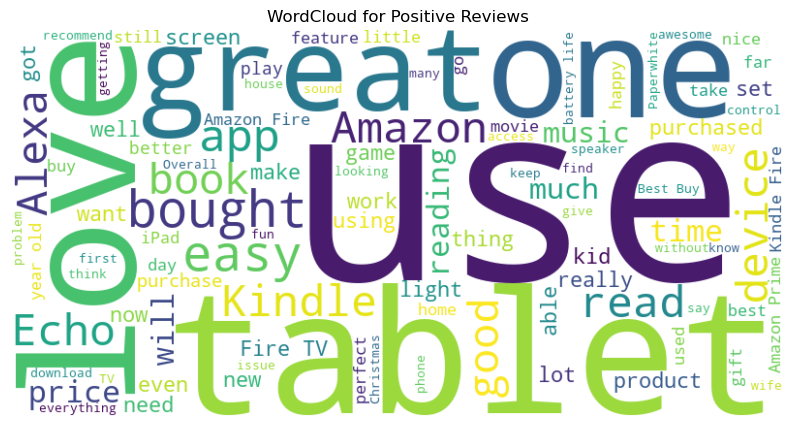

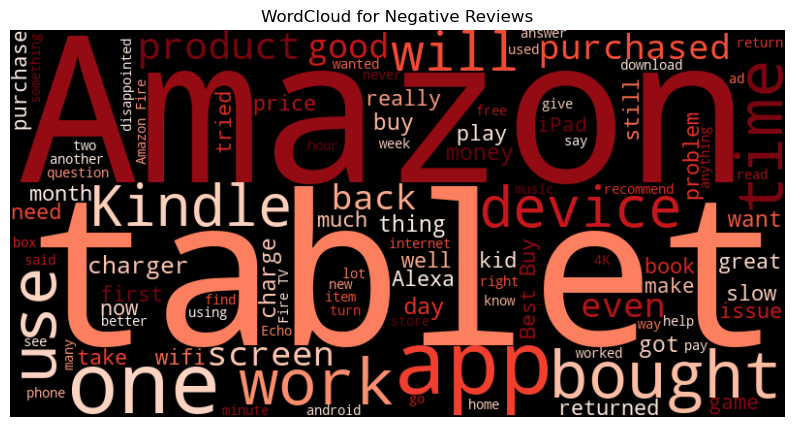

In [78]:
# Filter positive and negative reviews based on sentiment
positive_reviews = data[data['sentiment'] == 'Positive']['reviews.text']
negative_reviews = data[data['sentiment'] == 'Negative']['reviews.text']

# Combine all positive and negative reviews into a single string for each category
positive_text = " ".join(review for review in positive_reviews)
negative_text = " ".join(review for review in negative_reviews)

# Generate and display the word cloud for positive reviews
plt.figure(figsize=(10, 6))
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Positive Reviews")
plt.show()

# Generate and display the word cloud for negative reviews
plt.figure(figsize=(10, 6))
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', max_words=100, colormap='Reds').generate(negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Negative Reviews")
plt.show()